In [40]:
# import libraries
import tensorflow as tf # for modell training
import math
import cv2 as cv
import matplotlib.pyplot as plt # to show graphical results
from matplotlib.ticker import MaxNLocator

In [2]:
# own modules
import modules.config as config
from modules.ai_dataset import ai_dataset
from modules.export_trained_model import export_trained_model

In [3]:
# import training and testing data into one class object
raw_data = ai_dataset(config.TRAINING_DATA)
#raw_data.load_data(config.TEST_DATA)
raw_data.resize(config.IMG_SIZE)
raw_data.shuffle()
raw_data.tf_ready()

100%|██████████| 843/843 [00:27<00:00, 30.61it/s]
Errors: 0; Exceptions: 0
1550 Images ready


In [4]:
raw_data.get_status()

Image Data: (1550, 300, 300, 3)
Label Data: (1550,)
Class labels: dict_items([('negative', 0), ('positive', 1)])


In [5]:
# list of optimizers
optimizers = ["adadelta", "adagrad", "adam", "adamax", "ftrl", "nadam", "rmsprop", "sgd"]

In [6]:
# split the raw data into training and test data
split_index = math.ceil(len(raw_data.get_tf_images()) * (1-config.PERCENT_TEST))

training_images = raw_data.get_tf_images()[0:split_index]
training_labels = raw_data.get_tf_labels()[0:split_index]

test_images = raw_data.get_tf_images()[split_index:]
test_labels = raw_data.get_tf_labels()[split_index:]

oss: 0.4488 - val_accuracy: 0.8710
Epoch 6/20
44/44 [==============================] - 65s 1s/step - loss: 0.0873 - accuracy: 0.9725 - val_loss: 0.3169 - val_accuracy: 0.9032
Epoch 7/20
44/44 [==============================] - 65s 1s/step - loss: 0.0661 - accuracy: 0.9859 - val_loss: 0.3281 - val_accuracy: 0.8839
Epoch 8/20
44/44 [==============================] - 65s 1s/step - loss: 0.0447 - accuracy: 0.9961 - val_loss: 0.3170 - val_accuracy: 0.8839
Epoch 9/20
44/44 [==============================] - 65s 1s/step - loss: 0.0413 - accuracy: 0.9964 - val_loss: 0.3422 - val_accuracy: 0.8968
Epoch 10/20
44/44 [==============================] - 65s 1s/step - loss: 0.0316 - accuracy: 0.9993 - val_loss: 0.3194 - val_accuracy: 0.8903
Epoch 11/20
44/44 [==============================] - 65s 1s/step - loss: 0.0270 - accuracy: 0.9992 - val_loss: 0.3193 - val_accuracy: 0.8903
Epoch 12/20
44/44 [==============================] - 65s 1s/step - loss: 0.0255 - accuracy: 0.9978 - val_loss: 0.3007 - val

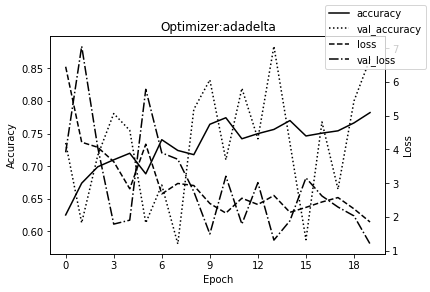

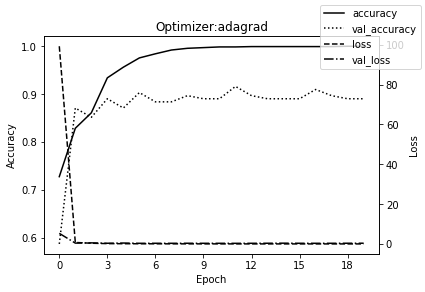

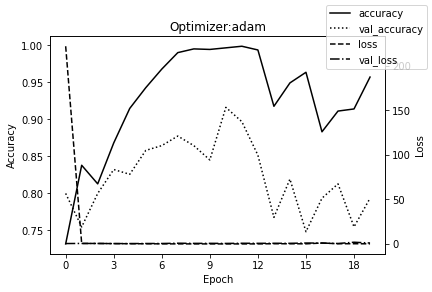

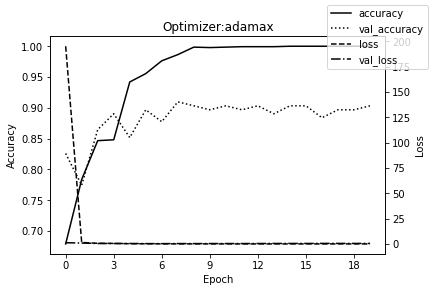

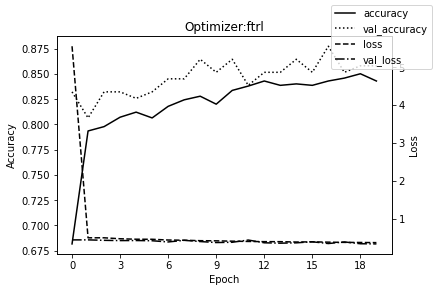

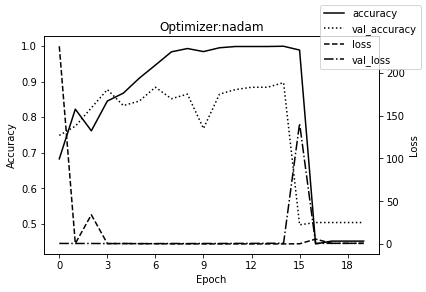

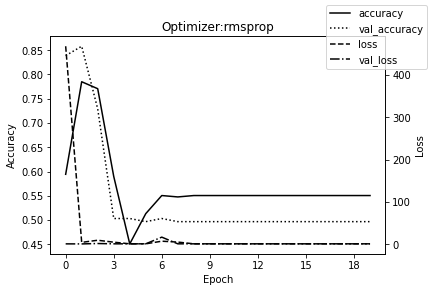

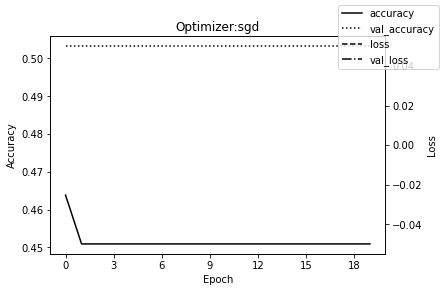

In [7]:
# train a model on each optimizer
for optim in optimizers:

    # print current optimizer
    print("Current Optimizer: "+optim)

    # Create the convolutional base
    model = tf.keras.models.Sequential(name=optim)
    model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(config.IMG_SIZE, config.IMG_SIZE, 3)))
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))
    model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D((2, 2)))
    model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))

    # Add Dense layers on top
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(64, activation='relu'))
    model.add(tf.keras.layers.Dense(raw_data.get_labels_count()))

    # model.summary()

    # compile the model
    model.compile(optimizer=optim,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

    # train the model
    history = model.fit(training_images, training_labels, epochs=config.TRAINING_EPOCHS,
              validation_data=(test_images, test_labels))

    # Plot learning curve
    fig = plt.figure()
    ax1 = fig.add_subplot()
    ax2 = ax1.twinx()
    ax1.plot(history.history["accuracy"], label = "accuracy", color = "k", linestyle = "solid")
    ax1.plot(history.history["val_accuracy"], label = "val_accuracy", color = "k", linestyle = "dotted")
    ax2.plot(history.history["loss"], label = "loss", color = "k", linestyle = "dashed")
    ax2.plot(history.history["val_loss"], label = "val_loss", color = "k", linestyle = "dashdot")
    ax1.set_xlabel("Epoch")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax1.set_ylabel("Accuracy")
    ax2.set_ylabel("Loss")
    fig.legend()
    ax1.set_title("Optimizer:"+optim)

    # evaluate model
    test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)

    # export the trained model
    export_trained_model(model, config.TRAINING_EPOCHS, test_loss, test_acc, history, fig, raw_data, config.MODEL_PATH)

In [46]:
# export test images for predictions
if True:
    if not os.path.exists(config.MODEL_PATH+"/val_img"):
        os.makedirs(config.MODEL_PATH+"/val_img", exist_ok=True)

    for i in range(split_index, len(raw_data.get_tf_images())):
        cv.imwrite(config.MODEL_PATH+"/val_img/"+str(i)+"_"+raw_data.get_label(i)+".png",raw_data.get_image(i))